# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KDTree
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from numpy import array
import itertools
from prettytable import PrettyTable # for printing data in tabular format

C:\Users\vajrapra\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [ ]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for KNN assignment you can take 20k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [ ]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [ ]:
print(display.shape)
display.head()

In [ ]:
display[display['UserId']=='AZY10LLTJ71NX']

In [ ]:
display['COUNT(*)'].sum()

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [ ]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [ ]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [ ]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

In [ ]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [ ]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

In [ ]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [ ]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

#### Balancing the data set

In [16]:
neg_df = final[final['Score']==0].sample(axis = 0, n=10000)
pos_df = final[final['Score']==1].sample(axis = 0, n=10000)
final = pd.concat([neg_df,pos_df])
final.shape
print(final['Score'].value_counts())

1    10000
0    10000
Name: Score, dtype: int64


#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [17]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

This is the grossest vile green puree of what looks like a babies rear has been near.... except for the chunks of cottage cheese???  Is that what that stuff was that was more like tofu, also in a nasty green puree... stay away...far, far away!<br /><br />Tell you what if you want to see for yourself, as I have 5 of the 6 packages left.  Send me a SASE and i'll gladly poop it to you ... no problem...
My 10-month daughter does like eating these rick rusks, so we ordered some.<br />We are very angry after we received them and found all of them will be expired on this Aug. And these products can not be returned.<br />We do not know why they do not show us the expire date of their products?
I am glad I got the chance to use this tea in my Keurig but my advice is to go back to make it the old-fashioned way, it delivers a huge difference in taste using K-cups. You might like it but never me
I was disappointed with the flavor of these. I really love the taste of nutritional yeast (I'm a vegan)

In [18]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

This is the grossest vile green puree of what looks like a babies rear has been near.... except for the chunks of cottage cheese???  Is that what that stuff was that was more like tofu, also in a nasty green puree... stay away...far, far away!<br /><br />Tell you what if you want to see for yourself, as I have 5 of the 6 packages left.  Send me a SASE and i'll gladly poop it to you ... no problem...


In [19]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

This is the grossest vile green puree of what looks like a babies rear has been near.... except for the chunks of cottage cheese???  Is that what that stuff was that was more like tofu, also in a nasty green puree... stay away...far, far away!Tell you what if you want to see for yourself, as I have 5 of the 6 packages left.  Send me a SASE and i'll gladly poop it to you ... no problem...
My 10-month daughter does like eating these rick rusks, so we ordered some.We are very angry after we received them and found all of them will be expired on this Aug. And these products can not be returned.We do not know why they do not show us the expire date of their products?
I am glad I got the chance to use this tea in my Keurig but my advice is to go back to make it the old-fashioned way, it delivers a huge difference in taste using K-cups. You might like it but never me
I was disappointed with the flavor of these. I really love the taste of nutritional yeast (I'm a vegan) but the only discernabl

In [20]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [21]:
sent_4900 = decontracted(sent_4900)
print(sent_4900)
print("="*50)

I was disappointed with the flavor of these. I really love the taste of nutritional yeast (I am a vegan) but the only discernable flavor of these doodles was salt. I do not know why nutritional yeast is listed as one of the ingredients and the flavor non-existent. I think it may have been a marketing ploy to entice "health nuts" and vegans to buy them. It is too bad since nutritional yeast is so full of nutrients and flavor. If you are a vegan, do not waste your money!! Go makes some popcorn and sprinkle some nutrional yeast over it.... it is much less expensive and healthier than these lousy things, I mean "Tings".


In [22]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

This is the grossest vile green puree of what looks like a babies rear has been near.... except for the chunks of cottage cheese???  Is that what that stuff was that was more like tofu, also in a nasty green puree... stay away...far, far away!<br /><br />Tell you what if you want to see for yourself, as I have  of the  packages left.  Send me a SASE and i'll gladly poop it to you ... no problem...


In [23]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

I am glad I got the chance to use this tea in my Keurig but my advice is to go back to make it the old fashioned way it delivers a huge difference in taste using K cups You might like it but never me


In [24]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [25]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████| 20000/20000 [00:09<00:00, 2180.66it/s]


In [26]:
preprocessed_reviews[1500]

'glad got chance use tea keurig advice go back make old fashioned way delivers huge difference taste using k cups might like never'

In [27]:
preprocessed_reviews = list(array(preprocessed_reviews))

In [28]:
score = final['Score']
score.reset_index(inplace = True, drop = True)
type(score)

pandas.core.series.Series

In [29]:
reviews_tr, reviews_ts, score_tr, score_ts = \
train_test_split(preprocessed_reviews, score, test_size=0.40, random_state=42)

In [30]:
ind_tr = score_tr.index.tolist()
ind_ts = score_ts.index.tolist()

In [31]:
# splitting into test and train data set in 40:60 ratio
print("data points in train data set is:",len(reviews_tr))
print("data points in test data set is:",len(reviews_ts))

data points in train data set is: 12000
data points in test data set is: 8000


In [32]:
score_tr.value_counts()

1    6026
0    5974
Name: Score, dtype: int64

In [33]:
score_ts.value_counts()

0    4026
1    3974
Name: Score, dtype: int64

# [4] Featurization

## [4.3] Word2Vec

In [34]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in reviews_tr:
    list_of_sentance.append(sentance.split())

In [35]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('good', 0.8312082290649414), ('excellent', 0.7909795045852661), ('makes', 0.7025638818740845), ('decent', 0.6888296604156494), ('especially', 0.6871694326400757), ('reasonable', 0.6795275211334229), ('quick', 0.6750308275222778), ('wonderful', 0.6653773784637451), ('beat', 0.6621816754341125), ('looking', 0.6586034297943115)]
[('ever', 0.919545590877533), ('licorice', 0.8819770812988281), ('far', 0.8718487024307251), ('ive', 0.870471715927124), ('macchiato', 0.8687818646430969), ('combinations', 0.8681186437606812), ('preferences', 0.8625591397285461), ('expert', 0.856567919254303), ('hazelnut', 0.8564282655715942), ('enjoyed', 0.8560640811920166)]


In [36]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  6990
sample words  ['one', 'better', 'peanut', 'butters', 'particularly', 'nice', 'consistent', 'butter', 'smoother', 'regard', 'jif', 'however', 'planters', 'bit', 'saltier', 'since', 'use', 'little', 'salt', 'food', 'preference', 'compared', 'favorite', 'salty', 'think', 'may', 'something', 'people', 'report', 'particular', 'salted', 'peanuts', 'hand', 'tends', 'sweeter', 'thicker', 'simply', 'even', 'less', 'uses', 'molasses', 'sweeteners', 'really', 'like', 'two', 'otherwise', 'worlds', 'apart', 'fresh', 'taste']


## [4.3.1] Converting text into vectors using Avg W2V, TFIDF-W2V

In [37]:
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

#### [4.3.1.1] Avg W2v

In [38]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|███████████████████████████████████| 20000/20000 [00:31<00:00, 637.60it/s]


20000
50


In [39]:
tr_avgW2V = list(array(sent_vectors)[ind_tr])
ts_avgW2V = list(array(sent_vectors)[ind_ts])

#### [4.3.1.2] TFIDF weighted W2v

In [40]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
model.fit(reviews_tr)
tf_idf_matrix = model.transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [41]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|████████████████████████████████████| 20000/20000 [03:32<00:00, 94.05it/s]


In [42]:
tr_tfidfW2V = list(array(tfidf_sent_vectors)[ind_tr])
ts_tfidfW2V = list(array(tfidf_sent_vectors)[ind_ts])

# [5] Assignment 3: KNN

<ol>
    <li><strong>Apply Knn(brute force version) on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Apply Knn(kd tree version) on these feature sets</strong>
        <br><font color='red'>NOTE: </font>sklearn implementation of kd-tree accepts only dense matrices, you need to convert the sparse matrices of CountVectorizer/TfidfVectorizer into dense matices. You can convert sparse matrices to dense using .toarray() attribute. For more information please visit this <a href='https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.sparse.csr_matrix.toarray.html'>link</a>
        <ul>
            <li><font color='red'>SET 5:</font>Review text, preprocessed one converted into vectors using (BOW) but with restriction on maximum features generated.
            <pre>
            count_vect = CountVectorizer(min_df=10, max_features=500) 
            count_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 6:</font>Review text, preprocessed one converted into vectors using (TFIDF) but with restriction on maximum features generated.
            <pre>
                tf_idf_vect = TfidfVectorizer(min_df=10, max_features=500)
                tf_idf_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best K)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'> link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

In [54]:
def plot_confusion_matrix(cm, classes,
                          cmap=plt.cm.Blues):
    
    title = 'Confusion matrix, without normalization'
    plt.figure(figsize=(20, 4))
    plt.subplot(1,2,1)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
     
    title = "Normalized confusion matrix"
    plt.subplot(1,2,2)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()   

## [5.1] Applying KNN brute force

### [5.1.1] Applying KNN brute force on BOW,<font color='red'> SET 1</font>

### BAG OF WORDS

Since the #data points taken for training are small, we need to make sure the #columns/features are lower than the #rows. Else, there will be issues of curse of dimensionality. Hence, filtering the words having document frequency less than 3 also, removing all the high document frequency words one occuring more than 80% of the documents. Since, they are so common in all the documents, they don't add much variance to the data, hence, removing the low variance words.

In [41]:
#BoW
count_vect = CountVectorizer(min_df = 5, max_df = 0.8, binary = False) #in scikit-learn
count_vect.fit(reviews_tr)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

print("train data:")
tr_count = count_vect.transform(reviews_tr)
print("the type of count vectorizer ",type(tr_count))
print("the shape of out text BOW vectorizer ",tr_count.get_shape())
print("the number of unique words ", tr_count.get_shape()[1])
print('='*50)

print("test data:")
ts_count = count_vect.transform(reviews_ts)
print("the shape of out text BOW vectorizer ",ts_count.get_shape())


some feature names  ['abdominal', 'ability', 'able', 'absolute', 'absolutely', 'absorb', 'absorbed', 'absurd', 'abundance', 'abundant']
train data:
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (12000, 6530)
the number of unique words  6530
test data:
the shape of out text BOW vectorizer  (8000, 6530)


In [42]:
score_tr.value_counts()/score_tr.shape

1    0.502167
0    0.497833
Name: Score, dtype: float64

##### Standardising the data

The BOW features that we are using isnt binary. Since KNN is a distance based method, we need to standardize the data before applying KNN. Since, BOW features is of type sparse matrix, standardization can make the matrix dense, hence, we need to make sure we standardize with paramater 'with_mean = False'. In this case standardization doesnt result in dense matrix, since we are just making the standard error 1 without changing the data mean to 0.

In [43]:
scaler = StandardScaler(with_mean=False)
scaler.fit(tr_count)
tr_std_count = scaler.transform(tr_count)
ts_std_count = scaler.transform(ts_count)

C:\Users\vajrapra\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\vajrapra\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\vajrapra\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


There are many distance metrics that can be used to get the neighborhood points from a point. Euclidian, Manhattan, Minkowski etc. We are using Euclidian distance which is nothing but Minkowski with p = 2 

In [44]:
tr_score = []
cv_score = []
K = []
for k in range(5,150,4):
    KNN = KNeighborsClassifier(n_neighbors=k,weights= 'distance', metric= 'minkowski',algorithm = 'brute',p=2)
    KNN_model = KNN.fit(tr_std_count,score_tr)
    K.append(k)
    tr_pred = KNN_model.predict_proba(tr_std_count)[:,1]
    ts_pred = KNN_model.predict_proba(ts_std_count)[:,1]
    tr_score.append(roc_auc_score(score_tr, tr_pred))
    cv_score.append(roc_auc_score(score_ts, ts_pred))
    print('Test AUC with k = %d is %.2g' % (k, roc_auc_score(score_ts, ts_pred)))

Test AUC with k = 5 is 0.63
Test AUC with k = 9 is 0.62
Test AUC with k = 13 is 0.62
Test AUC with k = 17 is 0.62
Test AUC with k = 21 is 0.64
Test AUC with k = 25 is 0.65
Test AUC with k = 29 is 0.68
Test AUC with k = 33 is 0.7
Test AUC with k = 37 is 0.71
Test AUC with k = 41 is 0.72
Test AUC with k = 45 is 0.73
Test AUC with k = 49 is 0.73
Test AUC with k = 53 is 0.74
Test AUC with k = 57 is 0.75
Test AUC with k = 61 is 0.76
Test AUC with k = 65 is 0.76
Test AUC with k = 69 is 0.75
Test AUC with k = 73 is 0.76
Test AUC with k = 77 is 0.76
Test AUC with k = 81 is 0.77
Test AUC with k = 85 is 0.77
Test AUC with k = 89 is 0.77
Test AUC with k = 93 is 0.77
Test AUC with k = 97 is 0.78
Test AUC with k = 101 is 0.78
Test AUC with k = 105 is 0.78
Test AUC with k = 109 is 0.78
Test AUC with k = 113 is 0.79
Test AUC with k = 117 is 0.79
Test AUC with k = 121 is 0.8
Test AUC with k = 125 is 0.8
Test AUC with k = 129 is 0.8
Test AUC with k = 133 is 0.8
Test AUC with k = 137 is 0.8
Test AUC wit

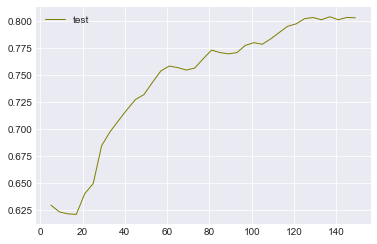

In [50]:
# graph comparing AUC's of test and train
d = {'K':K,'train':tr_score,'test':cv_score}
line_df = pd.DataFrame(data = d)
#line_df = pd.melt(line_df, id_vars = 'K', value_vars = ['train','test'], var_name = 'data', value_name = 'AUC')
#ax = sns.lineplot(x = "K", y = 'AUC', hue = 'data', data = line_df)
plt.style.use('seaborn-darkgrid')
plt.title('Brute Force KNN with BOW')
plt.xlabel('Hyper Parameter (K)')
plt.ylabel('AUC')
#plt.plot('K','train',linewidth = 1, color = 'skyblue', data = line_df)
plt.plot('K','test',linewidth = 1, color = 'olive', data = line_df)
plt.legend()
plt.show()

#### Observations:

Best AUC (80%) achieved with Brute Force KNN with BOW featurization is at K = 149

In [ ]:
KNN = KNeighborsClassifier(n_neighbors= 149,weights= 'distance', metric= 'minkowski',algorithm = 'brute',p=2)
KNN_BOW = KNN.fit(tr_std_count,score_tr)
tr_pred_KNN_BOW = KNN_BOW.predict_proba(tr_std_count)[:,1]
ts_pred_KNN_BOW = KNN_BOW.predict_proba(ts_std_count)[:,1]
auc_KNN_BOW = roc_auc_score(score_ts,ts_pred_KNN_BOW)

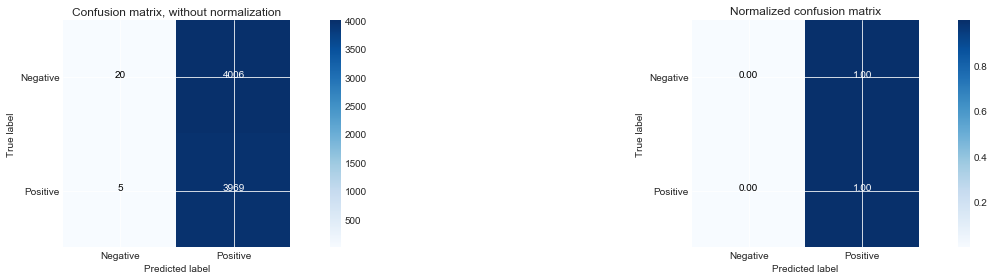

In [57]:
ts_pred = KNN_BOW.predict(ts_std_count)
cm_KNN_BOW = confusion_matrix(score_ts,ts_pred)
plot_confusion_matrix(cm_KNN_BOW, ['Negative', 'Positive'])

Though the AUC is high, we see the accuracy is too low for the model. Model predicts every data point as positive class.

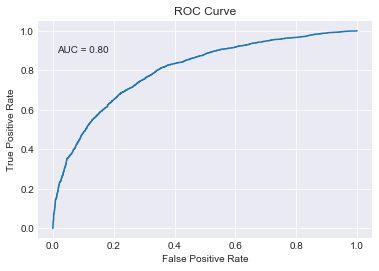

In [78]:
fpr, tpr, threshold = metrics.roc_curve(score_ts, ts_pred_KNN_BOW)
plt.plot(fpr,tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('ROC Curve')
plt.text(0.1,0.9,verticalalignment='center', horizontalalignment='center', s = 'AUC = 0.80', fontsize = 10)
plt.show() 

### [5.1.2] Applying KNN brute force on TFIDF,<font color='red'> SET 2</font>

### TF-IDF

Since the #data points taken for training are small, we need to make sure the #columns/features are lower than the #rows. Else, there will be issues of curse of dimensionality. Hence, filtering the words having document frequency less than 10 also, removing all the high document frequency words one occuring more than 80% of the documents. Since, they are so common in all the documents, they don't add much variance to the data, hence, removing the low variance words.

In [80]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10, max_df = 0.8)
tf_idf_vect.fit(reviews_tr)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

print("train data:")
tr_tfidf = tf_idf_vect.transform(reviews_tr)
print("the type of count vectorizer ",type(tr_tfidf))
print("the shape of out text TFIDF vectorizer ",tr_tfidf.get_shape())
print("the number of unique words including both unigrams and bigrams ", tr_tfidf.get_shape()[1])
print('='*50)

print("test data:")
ts_tfidf = tf_idf_vect.transform(reviews_ts)
print("the shape of out text TFIDF vectorizer ",ts_tfidf.get_shape())

some sample features(unique words in the corpus) ['ability', 'able', 'able buy', 'able eat', 'able find', 'able get', 'able make', 'able use', 'absolute', 'absolutely']
train data:
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (12000, 7477)
the number of unique words including both unigrams and bigrams  7477
test data:
the shape of out text TFIDF vectorizer  (8000, 7477)


TFIDF features also needs to be standardised before applying KNN. We have to follow the similar steps as we did with BOW featurization

In [81]:
scaler = StandardScaler(with_mean=False)
scaler.fit(tr_tfidf)
tr_std_tfidf = scaler.transform(tr_tfidf)
ts_std_tfidf = scaler.transform(ts_tfidf)

In [83]:
# need to build a brute force KNN model with standardised tfidf features and find the best K (using AUC metric)
cv_score = []
tr_score = [] 
K = []
for k in range(5,150,4):
    KNN = KNeighborsClassifier(n_neighbors = k,metric = 'minkowski', p=2, algorithm = 'brute', weights = 'distance')
    model = KNN.fit(tr_std_tfidf,score_tr)
    K.append(k)
    tr_pred = model.predict_proba(tr_std_tfidf)[:,1]
    ts_pred = model.predict_proba(ts_std_tfidf)[:,1]
    tr_score.append(roc_auc_score(score_tr,tr_pred))
    cv_score.append(roc_auc_score(score_ts,ts_pred))
    print('Test AUC with k = %d is %.2g' % (k, roc_auc_score(score_ts, ts_pred)))

Test AUC with k = 5 is 0.51
Test AUC with k = 9 is 0.52
Test AUC with k = 13 is 0.52
Test AUC with k = 17 is 0.51
Test AUC with k = 21 is 0.52
Test AUC with k = 25 is 0.58
Test AUC with k = 29 is 0.63
Test AUC with k = 33 is 0.64
Test AUC with k = 37 is 0.62
Test AUC with k = 41 is 0.66
Test AUC with k = 45 is 0.67
Test AUC with k = 49 is 0.67
Test AUC with k = 53 is 0.69
Test AUC with k = 57 is 0.71
Test AUC with k = 61 is 0.7
Test AUC with k = 65 is 0.7
Test AUC with k = 69 is 0.71
Test AUC with k = 73 is 0.73
Test AUC with k = 77 is 0.73
Test AUC with k = 81 is 0.73
Test AUC with k = 85 is 0.73
Test AUC with k = 89 is 0.73
Test AUC with k = 93 is 0.74
Test AUC with k = 97 is 0.76
Test AUC with k = 101 is 0.76
Test AUC with k = 105 is 0.75
Test AUC with k = 109 is 0.76
Test AUC with k = 113 is 0.77
Test AUC with k = 117 is 0.78
Test AUC with k = 121 is 0.77
Test AUC with k = 125 is 0.77
Test AUC with k = 129 is 0.78
Test AUC with k = 133 is 0.79
Test AUC with k = 137 is 0.79
Test AUC

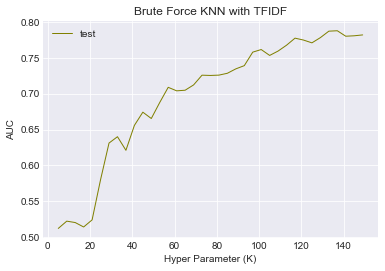

In [85]:
# graph comparing AUC's of test and train
d = {'K':K,'train':tr_score,'test':cv_score}
line_df = pd.DataFrame(data = d)
plt.style.use('seaborn-darkgrid')
plt.title('Brute Force KNN with TFIDF')
plt.xlabel('Hyper Parameter (K)')
plt.ylabel('AUC')
#plt.plot('K','train',linewidth = 1, color = 'skyblue', data = line_df)
plt.plot('K','test',linewidth = 1, color = 'olive', data = line_df)
plt.legend()
plt.show()

#### Observations:

Brute Force KNN with TFIDF featurization is poor than BOW features and the best AUC (79%) is achieved with K = 133.

In [86]:
KNN = KNeighborsClassifier(n_neighbors= 133,weights= 'distance', metric= 'minkowski',algorithm = 'brute',p=2)
KNN_TFIDF = KNN.fit(tr_std_tfidf,score_tr)
tr_pred_KNN_TFIDF = KNN_TFIDF.predict_proba(tr_std_tfidf)[:,1]
ts_pred_KNN_TFIDF = KNN_TFIDF.predict_proba(ts_std_tfidf)[:,1]
auc_KNN_TFIDF = roc_auc_score(score_ts,ts_pred_KNN_TFIDF)

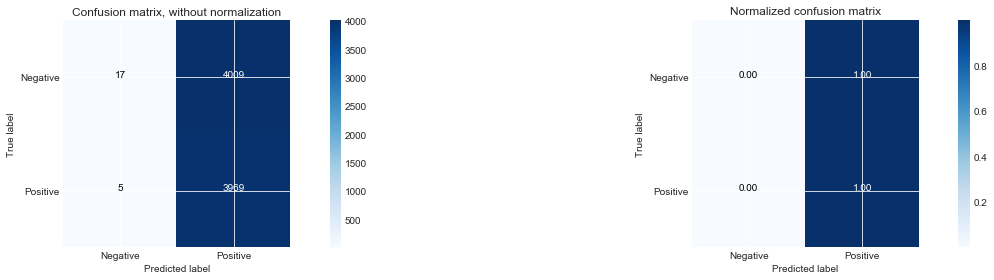

In [88]:
ts_pred = KNN_TFIDF.predict(ts_std_tfidf)
cm_KNN_TFIDF = confusion_matrix(score_ts,ts_pred)
plot_confusion_matrix(cm_KNN_TFIDF, ['Negative', 'Positive'])

Though the AUC is high, we see the accuracy is too low for the model. Model predicts every data point as positive class.

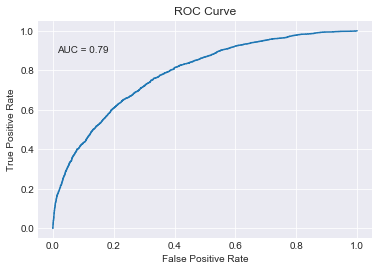

In [89]:
fpr, tpr, threshold = metrics.roc_curve(score_ts, ts_pred_KNN_TFIDF)
plt.plot(fpr,tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('ROC Curve')
plt.text(0.1,0.9,verticalalignment='center', horizontalalignment='center', s = 'AUC = 0.79', fontsize = 10)
plt.show() 

### [5.1.3] Applying KNN brute force on AVG W2V,<font color='red'> SET 3</font>

In [90]:
scaler = StandardScaler()
scaler.fit(tr_avgW2V)
tr_std_avgW2V = scaler.transform(tr_avgW2V)
ts_std_avgW2V = scaler.transform(ts_avgW2V)

In [91]:
cv_score = []
tr_score = [] 
K = []
for k in range(5,150,4):
    KNN = KNeighborsClassifier(n_neighbors = k,metric = 'minkowski', p=2, algorithm = 'brute', weights = 'distance')
    model = KNN.fit(tr_std_avgW2V,score_tr)
    K.append(k)
    tr_pred = model.predict_proba(tr_std_avgW2V)[:,1]
    ts_pred = model.predict_proba(ts_std_avgW2V)[:,1]
    tr_score.append(roc_auc_score(score_tr,tr_pred))
    cv_score.append(roc_auc_score(score_ts,ts_pred))
    print('Test AUC with k = %d is %.2g' % (k, roc_auc_score(score_ts, ts_pred)))

Test AUC with k = 5 is 0.79
Test AUC with k = 9 is 0.81
Test AUC with k = 13 is 0.82
Test AUC with k = 17 is 0.83
Test AUC with k = 21 is 0.83
Test AUC with k = 25 is 0.84
Test AUC with k = 29 is 0.84
Test AUC with k = 33 is 0.84
Test AUC with k = 37 is 0.84
Test AUC with k = 41 is 0.84
Test AUC with k = 45 is 0.84
Test AUC with k = 49 is 0.84
Test AUC with k = 53 is 0.84
Test AUC with k = 57 is 0.84
Test AUC with k = 61 is 0.84
Test AUC with k = 65 is 0.84
Test AUC with k = 69 is 0.84
Test AUC with k = 73 is 0.84
Test AUC with k = 77 is 0.84
Test AUC with k = 81 is 0.84
Test AUC with k = 85 is 0.84
Test AUC with k = 89 is 0.84
Test AUC with k = 93 is 0.84
Test AUC with k = 97 is 0.84
Test AUC with k = 101 is 0.84
Test AUC with k = 105 is 0.84
Test AUC with k = 109 is 0.83
Test AUC with k = 113 is 0.83
Test AUC with k = 117 is 0.83
Test AUC with k = 121 is 0.83
Test AUC with k = 125 is 0.83
Test AUC with k = 129 is 0.83
Test AUC with k = 133 is 0.83
Test AUC with k = 137 is 0.83
Test A

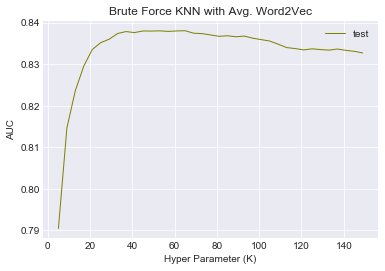

In [92]:
# graph comparing AUC's of test and train
d = {'K':K,'train':tr_score,'test':cv_score}
line_df = pd.DataFrame(data = d)
plt.style.use('seaborn-darkgrid')
plt.title('Brute Force KNN with Avg. Word2Vec')
plt.xlabel('Hyper Parameter (K)')
plt.ylabel('AUC')
#plt.plot('K','train',linewidth = 1, color = 'skyblue', data = line_df)
plt.plot('K','test',linewidth = 1, color = 'olive', data = line_df)
plt.legend()
plt.show()

####  Observations:

Brute Force KNN with AvgW2V featurization is better than BOW features and the best AUC (84%) is achieved with K = 25

In [94]:
KNN = KNeighborsClassifier(n_neighbors=25,weights= 'distance', metric= 'minkowski',algorithm = 'brute',p=2)
KNN_avgW2V = KNN.fit(tr_std_avgW2V,score_tr)
tr_pred_KNN_avgW2V = KNN_avgW2V.predict_proba(tr_std_avgW2V)[:,1]
ts_pred_KNN_avgW2V = KNN_avgW2V.predict_proba(ts_std_avgW2V)[:,1]
auc_KNN_avgW2V = roc_auc_score(score_ts,ts_pred_KNN_avgW2V)

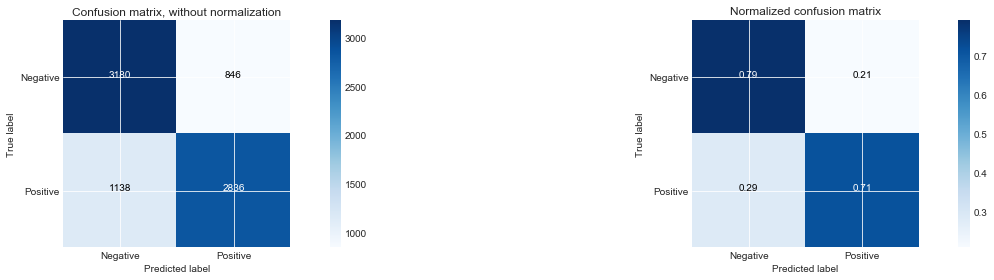

In [96]:
ts_pred = KNN_avgW2V.predict(ts_std_avgW2V)
cm_KNN_avgW2V = confusion_matrix(score_ts,ts_pred)
plot_confusion_matrix(cm_KNN_avgW2V, ['Negative', 'Positive'])

Accuracy of the model also seems to improve with Average Word2Vec model. Model seems to predict both positive and negative labels.

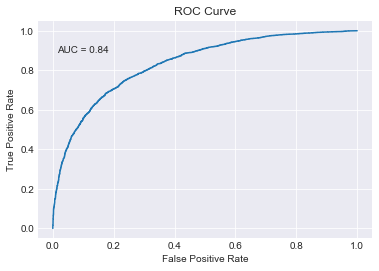

In [97]:
fpr, tpr, threshold = metrics.roc_curve(score_ts, ts_pred_KNN_avgW2V)
plt.plot(fpr,tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('ROC Curve')
plt.text(0.1,0.9,verticalalignment='center', horizontalalignment='center', s = 'AUC = 0.84', fontsize = 10)
plt.show() 

### [5.1.4] Applying KNN brute force on TFIDF W2V,<font color='red'> SET 4</font>

In [98]:
scaler = StandardScaler()
scaler.fit(tr_tfidfW2V)
tr_std_tfidfW2V = scaler.transform(tr_tfidfW2V)
ts_std_tfidfW2V = scaler.transform(ts_tfidfW2V)

In [99]:
cv_score = []
tr_score = [] 
K = [] 
for k in range(5,150,4):
    KNN = KNeighborsClassifier(n_neighbors = k,metric = 'minkowski', p=2, algorithm = 'brute', weights = 'distance')
    model = KNN.fit(tr_std_tfidfW2V,score_tr)
    K.append(k)
    tr_pred = model.predict_proba(tr_std_tfidfW2V)[:,1]
    ts_pred = model.predict_proba(ts_std_tfidfW2V)[:,1]
    tr_score.append(roc_auc_score(score_tr,tr_pred))
    cv_score.append(roc_auc_score(score_ts,ts_pred))
    print('Test AUC with k = %d is %.2g' % (k, roc_auc_score(score_ts, ts_pred)))

Test AUC with k = 5 is 0.76
Test AUC with k = 9 is 0.78
Test AUC with k = 13 is 0.79
Test AUC with k = 17 is 0.8
Test AUC with k = 21 is 0.8
Test AUC with k = 25 is 0.8
Test AUC with k = 29 is 0.8
Test AUC with k = 33 is 0.81
Test AUC with k = 37 is 0.81
Test AUC with k = 41 is 0.81
Test AUC with k = 45 is 0.81
Test AUC with k = 49 is 0.81
Test AUC with k = 53 is 0.81
Test AUC with k = 57 is 0.81
Test AUC with k = 61 is 0.81
Test AUC with k = 65 is 0.81
Test AUC with k = 69 is 0.81
Test AUC with k = 73 is 0.8
Test AUC with k = 77 is 0.8
Test AUC with k = 81 is 0.8
Test AUC with k = 85 is 0.8
Test AUC with k = 89 is 0.8
Test AUC with k = 93 is 0.8
Test AUC with k = 97 is 0.8
Test AUC with k = 101 is 0.8
Test AUC with k = 105 is 0.8
Test AUC with k = 109 is 0.8
Test AUC with k = 113 is 0.8
Test AUC with k = 117 is 0.8
Test AUC with k = 121 is 0.8
Test AUC with k = 125 is 0.8
Test AUC with k = 129 is 0.8
Test AUC with k = 133 is 0.8
Test AUC with k = 137 is 0.8
Test AUC with k = 141 is 0.

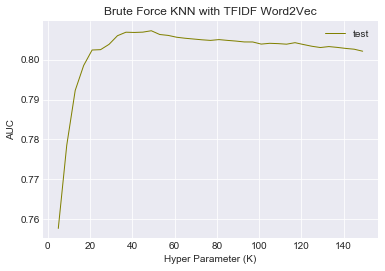

In [101]:
d = {'K': K, 'train' : tr_score, 'test' : cv_score}
line_df = pd.DataFrame(data = d)
plt.style.use('seaborn-darkgrid')
plt.title('Brute Force KNN with TFIDF Word2Vec')
plt.xlabel('Hyper Parameter (K)')
plt.ylabel('AUC')
#plt.plot('K','train',linewidth = 1, color = 'skyblue', data = line_df)
plt.plot('K','test',linewidth = 1, color = 'olive', data = line_df)
plt.legend()
plt.show()

####  Observations:

Brute Force KNN with TFIDFW2V featurization is equally good as AvgW2V model and the best AUC (81%) is achieved with K = 33

In [100]:
KNN = KNeighborsClassifier(n_neighbors=33,weights= 'distance', metric= 'minkowski',algorithm = 'brute',p=2)
KNN_tfidfW2V = KNN.fit(tr_std_tfidfW2V,score_tr)
tr_pred_KNN_tfidfW2V = KNN_tfidfW2V.predict_proba(tr_std_tfidfW2V)[:,1]
ts_pred_KNN_tfidfW2V = KNN_tfidfW2V.predict_proba(ts_std_tfidfW2V)[:,1]
auc_KNN_tfidfW2V = roc_auc_score(score_ts,ts_pred_KNN_tfidfW2V)

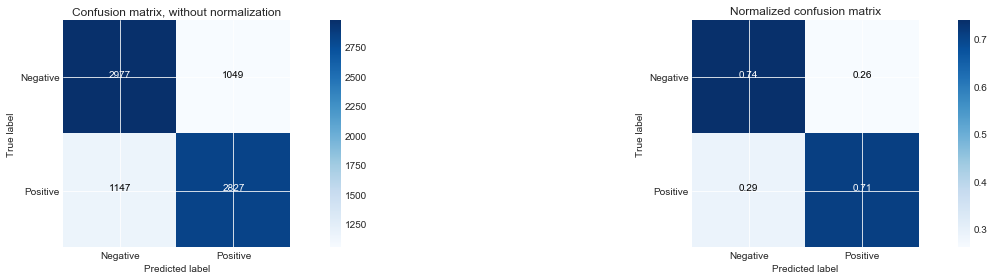

In [102]:
ts_pred = KNN_tfidfW2V.predict(ts_std_tfidfW2V)
cm_KNN_tfidfw2v = confusion_matrix(score_ts, ts_pred)
plot_confusion_matrix(cm_KNN_tfidfw2v,["Negative", "Positive"])

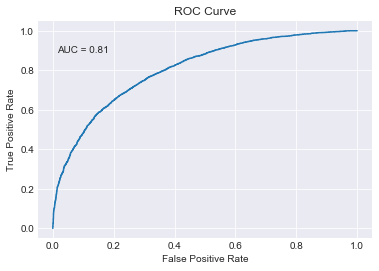

In [104]:
fpr, tpr, threshold = roc_curve(score_ts,ts_pred_KNN_tfidfW2V)
plt.plot(fpr,tpr)
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.text(0.1,0.9,verticalalignment='center', horizontalalignment='center', s = 'AUC = 0.81', fontsize = 10)
plt.show()

## [5.2] Applying KNN kd-tree

Kd-tree is a procedural alternative to KNN suitable when there are fewer dimensions and data points are uniformly distributed. It basically divides the region space in multiple regions with axis parallel hyper planes such that same #points on both the sides.

### [5.2.1] Applying KNN kd-tree on BOW,<font color='red'> SET 5</font>

Kd-tree doesnt work on sparse matrix. We need to convert the data to dense before applying Kd-tree. Also, we need to restict the features/dimensions of the data to 500, since Kd-tree is suitable for fewer dimensions only

#### Bag of Words featurization....

In [105]:
#BoW
count_vect = CountVectorizer(min_df = 5, max_df = 0.8, max_features = 500, binary = False) #in scikit-learn
count_vect.fit(reviews_tr)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

print("train data:")
tr_count = count_vect.transform(reviews_tr)
print("the type of count vectorizer ",type(tr_count))
print("the shape of out text BOW vectorizer ",tr_count.get_shape())
print("the number of unique words ", tr_count.get_shape()[1])
print('='*50)

print("test data:")
ts_count = count_vect.transform(reviews_ts)
print("the shape of out text BOW vectorizer ",ts_count.get_shape())

some feature names  ['able', 'absolutely', 'actually', 'add', 'added', 'aftertaste', 'ago', 'almost', 'also', 'although']
train data:
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (12000, 500)
the number of unique words  500
test data:
the shape of out text BOW vectorizer  (8000, 500)


#### Sparse to dense matrix....

In [106]:
from scipy.sparse import csr_matrix
tr_count_dense = csr_matrix.todense(tr_count)
ts_count_dense = csr_matrix.todense(ts_count)
print("Type of matrix is ", type(tr_count_dense))
print("Shape of train matrix has not changed:",tr_count_dense.shape)
print("Shape of test matrix has not changed:",ts_count_dense.shape)

Type of matrix is  <class 'numpy.matrixlib.defmatrix.matrix'>
Shape of train matrix has not changed: (12000, 500)
Shape of test matrix has not changed: (8000, 500)


#### Standardising the data....

In [107]:
scaler = StandardScaler(with_mean=True)
scaler.fit(tr_count_dense)
tr_std_count = scaler.transform(tr_count_dense)
ts_std_count = scaler.transform(ts_count_dense)

In [108]:
cv_score = []
tr_score = [] 
K = []
for k in range(5,100,4):
    Kdtree = KNeighborsClassifier(n_neighbors = k,metric = 'minkowski', p=2, algorithm = 'kd_tree', weights = 'distance')
    model = Kdtree.fit(tr_std_count,score_tr)
    K.append(k)
    tr_pred = model.predict_proba(tr_std_count)[:,1]
    ts_pred = model.predict_proba(ts_std_count)[:,1]
    tr_score.append(roc_auc_score(score_tr,tr_pred))
    cv_score.append(roc_auc_score(score_ts,ts_pred))
    print('Test AUC with k = %d is %.2g' % (k, roc_auc_score(score_ts, ts_pred)))

Test AUC with k = 5 is 0.73
Test AUC with k = 9 is 0.75
Test AUC with k = 13 is 0.75
Test AUC with k = 17 is 0.75
Test AUC with k = 21 is 0.75
Test AUC with k = 25 is 0.75
Test AUC with k = 29 is 0.76
Test AUC with k = 33 is 0.76
Test AUC with k = 37 is 0.77
Test AUC with k = 41 is 0.77
Test AUC with k = 45 is 0.77
Test AUC with k = 49 is 0.78
Test AUC with k = 53 is 0.78
Test AUC with k = 57 is 0.79
Test AUC with k = 61 is 0.79
Test AUC with k = 65 is 0.79
Test AUC with k = 69 is 0.79
Test AUC with k = 73 is 0.8
Test AUC with k = 77 is 0.8
Test AUC with k = 81 is 0.8
Test AUC with k = 85 is 0.8
Test AUC with k = 89 is 0.8
Test AUC with k = 93 is 0.81
Test AUC with k = 97 is 0.81


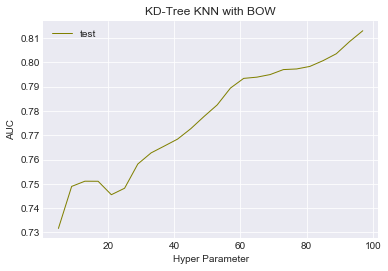

In [111]:
d = {'K':K,'train':tr_score,'test':cv_score}
line_df = pd.DataFrame(data = d)
plt.style.use("seaborn-darkgrid")
plt.plot('K','test',data = line_df, color = 'olive', linewidth = 1)
plt.xlabel("Hyper Parameter")
plt.ylabel("AUC")
plt.title('KD-Tree KNN with BOW')
plt.legend()
plt.show()

#### Observations:

Kdtree with BOW featurization is better than Brute Force KNN with BOW features and the best AUC (81%) is achieved with K = 93

In [112]:
Kdtree = KNeighborsClassifier(n_neighbors = 93 ,metric = 'minkowski', p=2, algorithm = 'kd_tree', weights = 'distance')
Kdtree_count = Kdtree.fit(tr_std_count,score_tr)
tr_pred_Kdtree_count = Kdtree_count.predict_proba(tr_std_count)[:,1]
ts_pred_Kdtree_count = Kdtree_count.predict_proba(ts_std_count)[:,1]
auc_Kdtree_count = roc_auc_score(score_ts,ts_pred_Kdtree_count)

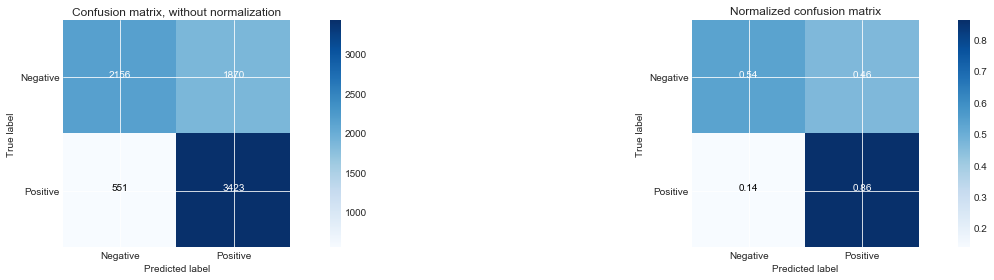

In [113]:
ts_pred = Kdtree_count.predict(ts_std_count)
cm_KDtree_bow = confusion_matrix(score_ts, ts_pred)
plot_confusion_matrix(cm_KDtree_bow,["Negative", "Positive"])

Accuracy of the model isnt that good but compared to KNN (with BOW), the accuracy is high

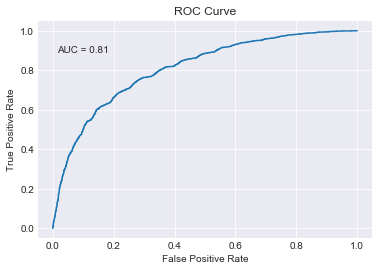

In [115]:
fpr, tpr, threshold = metrics.roc_curve(score_ts, ts_pred_Kdtree_count)
plt.plot(fpr,tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('ROC Curve')
plt.text(0.1,0.9,verticalalignment='center', horizontalalignment='center', s = 'AUC = 0.81', fontsize = 10)
plt.show() 

### [5.2.2] Applying KNN kd-tree on TFIDF,<font color='red'> SET 6</font>

#### TFIDF featurization....

In [43]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10, max_df = 0.8, max_features=500)
tf_idf_vect.fit(reviews_tr)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

print("train data:")
tr_tfidf = tf_idf_vect.transform(reviews_tr)
print("the type of count vectorizer ",type(tr_tfidf))
print("the shape of out text TFIDF vectorizer ",tr_tfidf.get_shape())
print("the number of unique words including both unigrams and bigrams ", tr_tfidf.get_shape()[1])
print('='*50)

print("test data:")
ts_tfidf = tf_idf_vect.transform(reviews_ts)
print("the shape of out text TFIDF vectorizer ",ts_tfidf.get_shape())

some sample features(unique words in the corpus) ['able', 'absolutely', 'actually', 'add', 'added', 'adding', 'aftertaste', 'ago', 'almost', 'also']
train data:
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (12000, 500)
the number of unique words including both unigrams and bigrams  500
test data:
the shape of out text TFIDF vectorizer  (8000, 500)


#### Sparse to dense matrix....

In [44]:
from scipy.sparse import csr_matrix
tr_tfidf_dense = csr_matrix.todense(tr_tfidf)
ts_tfidf_dense = csr_matrix.todense(ts_tfidf)
print("Type of matrix is ", type(tr_tfidf_dense))
print("Shape of train matrix has not changed:",tr_tfidf_dense.shape)
print("Shape of test matrix has not changed:",ts_tfidf_dense.shape)

Type of matrix is  <class 'numpy.matrixlib.defmatrix.matrix'>
Shape of train matrix has not changed: (12000, 500)
Shape of test matrix has not changed: (8000, 500)


#### Standardising the data....

In [45]:
scaler = StandardScaler(with_mean=True)
scaler.fit(tr_tfidf_dense)
tr_std_tfidf = scaler.transform(tr_tfidf_dense)
ts_std_tfidf = scaler.transform(ts_tfidf_dense)

In [46]:
cv_score = []
tr_score = [] 
K= []
for k in range(5,100,4):
    Kdtree = KNeighborsClassifier(n_neighbors = k,metric = 'minkowski', p=2, algorithm = 'kd_tree', weights = 'distance')
    model = Kdtree.fit(tr_std_tfidf,score_tr)
    K.append(k)
    tr_pred = model.predict_proba(tr_std_tfidf)[:,1]
    ts_pred = model.predict_proba(ts_std_tfidf)[:,1]
    tr_score.append(roc_auc_score(score_tr,tr_pred))
    cv_score.append(roc_auc_score(score_ts,ts_pred))
    print('Test AUC with k = %d is %.2g' % (k, roc_auc_score(score_ts, ts_pred)))

Test AUC with k = 5 is 0.59
Test AUC with k = 9 is 0.6
Test AUC with k = 13 is 0.59
Test AUC with k = 17 is 0.62
Test AUC with k = 21 is 0.61
Test AUC with k = 25 is 0.6
Test AUC with k = 29 is 0.61
Test AUC with k = 33 is 0.62
Test AUC with k = 37 is 0.71
Test AUC with k = 41 is 0.75
Test AUC with k = 45 is 0.77
Test AUC with k = 49 is 0.78
Test AUC with k = 53 is 0.79
Test AUC with k = 57 is 0.8
Test AUC with k = 61 is 0.8
Test AUC with k = 65 is 0.8
Test AUC with k = 69 is 0.81
Test AUC with k = 73 is 0.81
Test AUC with k = 77 is 0.81
Test AUC with k = 81 is 0.82
Test AUC with k = 85 is 0.82
Test AUC with k = 89 is 0.82
Test AUC with k = 93 is 0.82
Test AUC with k = 97 is 0.82


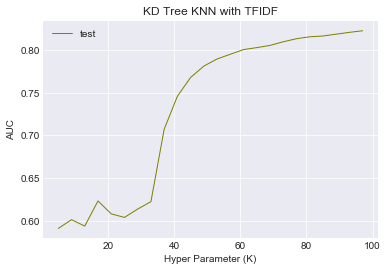

In [51]:
d = {'K':K,'train':tr_score,'test':cv_score}
line_df = pd.DataFrame(data = d)
plt.style.use('seaborn-darkgrid')
plt.title('KD Tree KNN with TFIDF')
plt.plot('K','test',data = line_df,linewidth = 1, color = 'olive')
plt.xlabel('Hyper Parameter (K)')
plt.ylabel('AUC')
plt.legend()
plt.show()

#### Observations:

Kdtree with TFIDF featurization is better than Kdtree with BOW features and the best AUC (82%) is achieved with K = 81

In [52]:
Kdtree = KNeighborsClassifier(n_neighbors = 81,metric = 'minkowski', p=2, algorithm = 'kd_tree', weights = 'distance')
Kdtree_tfidf = Kdtree.fit(tr_std_tfidf,score_tr)
tr_pred_Kdtree_tfidf = Kdtree_tfidf.predict_proba(tr_std_tfidf)[:,1]
ts_pred_Kdtree_tfidf = Kdtree_tfidf.predict_proba(ts_std_tfidf)[:,1]
auc_Kdtree_tfidf = roc_auc_score(score_ts,ts_pred_Kdtree_tfidf)

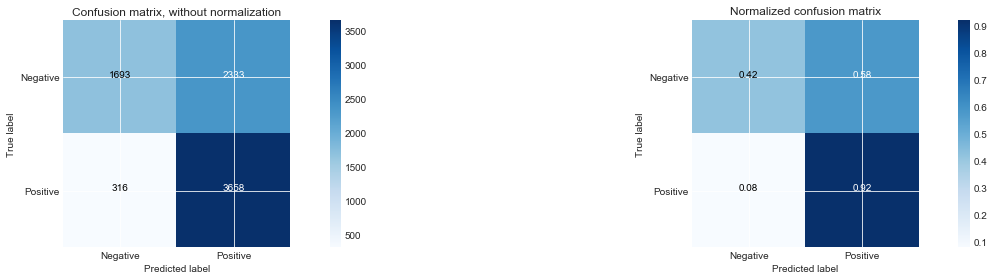

In [55]:
ts_pred = Kdtree_tfidf.predict(ts_std_tfidf)
cm_Kdtree_tfidf = confusion_matrix(score_ts,ts_pred)
plot_confusion_matrix(cm_Kdtree_tfidf,['Negative', 'Positive'])

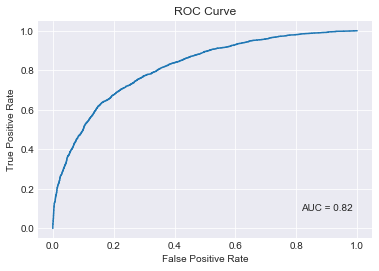

In [58]:
fpr, tpr, threshold = metrics.roc_curve(score_ts, ts_pred_Kdtree_tfidf)
plt.plot(fpr,tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.text(0.9,0.1, verticalalignment = 'center',  horizontalalignment='center', s = 'AUC = 0.82', fontsize = 10)
plt.show()

### [5.2.3] Applying KNN kd-tree on AVG W2V,<font color='red'> SET 3</font>

Word2Vec based features are already dense matrices, hence, there is no need of any conversion. Though we still need to standardise the data.

#### Standardising the data....

In [57]:
scaler = StandardScaler(with_mean=True)
scaler.fit(tr_avgW2V)
tr_std_avgW2V = scaler.transform(tr_avgW2V)
ts_std_avgW2V = scaler.transform(ts_avgW2V)

In [59]:
cv_score = []
tr_score = [] 
K = []
for k in range(5,100,4):
    Kdtree = KNeighborsClassifier(n_neighbors = k,metric = 'minkowski', p=2, algorithm = 'kd_tree', weights = 'distance')
    model = Kdtree.fit(tr_std_avgW2V,score_tr)
    tr_pred = model.predict_proba(tr_std_avgW2V)[:,1]
    ts_pred = model.predict_proba(ts_std_avgW2V)[:,1]
    K.append(k)
    tr_score.append(roc_auc_score(score_tr,tr_pred))
    cv_score.append(roc_auc_score(score_ts,ts_pred))
    print('Test AUC with k = %d is %.2g' % (k, roc_auc_score(score_ts, ts_pred)))

Test AUC with k = 5 is 0.79
Test AUC with k = 9 is 0.82
Test AUC with k = 13 is 0.82
Test AUC with k = 17 is 0.83
Test AUC with k = 21 is 0.83
Test AUC with k = 25 is 0.84
Test AUC with k = 29 is 0.84
Test AUC with k = 33 is 0.84
Test AUC with k = 37 is 0.84
Test AUC with k = 41 is 0.84
Test AUC with k = 45 is 0.84
Test AUC with k = 49 is 0.84
Test AUC with k = 53 is 0.84
Test AUC with k = 57 is 0.84
Test AUC with k = 61 is 0.84
Test AUC with k = 65 is 0.84
Test AUC with k = 69 is 0.84
Test AUC with k = 73 is 0.84
Test AUC with k = 77 is 0.84
Test AUC with k = 81 is 0.84
Test AUC with k = 85 is 0.84
Test AUC with k = 89 is 0.84
Test AUC with k = 93 is 0.84
Test AUC with k = 97 is 0.84


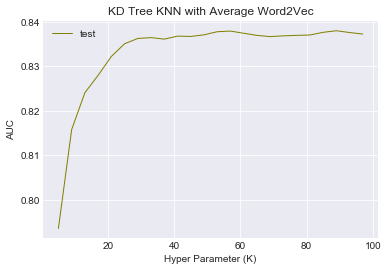

In [67]:
d = {'K':K,'train':tr_score,'test':cv_score}
line_df = pd.DataFrame(data = d)
plt.style.use('seaborn-darkgrid')
plt.plot('K','test',data = line_df, color = 'olive', linewidth = 1)
plt.xlabel('Hyper Parameter (K)')
plt.ylabel('AUC')
plt.title('KD Tree KNN with Average Word2Vec')
plt.legend()
plt.show()

#### Observations:

Kdtree with AvgW2V featurization is better than Kdtree with TFIDF features and the best AUC (84%) is achieved with K = 25

In [62]:
Kdtree = KNeighborsClassifier(n_neighbors = 25,metric = 'minkowski', p=2, algorithm = 'kd_tree', weights = 'distance')
Kdtree_avgW2V = Kdtree.fit(tr_std_avgW2V,score_tr)
tr_pred_Kdtree_avgW2V = Kdtree_avgW2V.predict_proba(tr_std_avgW2V)[:,1]
ts_pred_Kdtree_avgW2V = Kdtree_avgW2V.predict_proba(ts_std_avgW2V)[:,1]
auc_Kdtree_avgW2V_ts = roc_auc_score(score_ts,ts_pred_Kdtree_avgW2V)

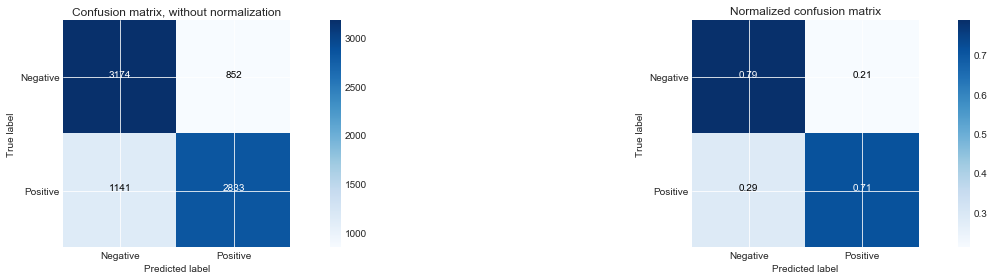

In [63]:
ts_pred = Kdtree_avgW2V.predict(ts_std_avgW2V)
cm_Kdtree_avgW2V = confusion_matrix(score_ts, ts_pred)
plot_confusion_matrix(cm_Kdtree_avgW2V,['Negative','Positive'])

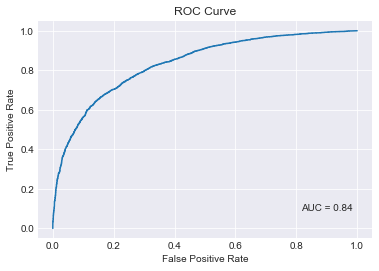

In [65]:
fpr, tpr, threshold = metrics.roc_curve(score_ts, ts_pred_Kdtree_avgW2V)
plt.plot(fpr,tpr)
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.text(0.9,0.1, verticalalignment = 'center', horizontalalignment = 'center', s = 'AUC = 0.84', fontsize = 10)
plt.show()

### [5.2.4] Applying KNN kd-tree on TFIDF W2V,<font color='red'> SET 4</font>

Standardising the data........

In [68]:
scaler = StandardScaler(with_mean=True)
scaler.fit(tr_tfidfW2V)
tr_std_tfidfW2V = scaler.transform(tr_tfidfW2V)
ts_std_tfidfW2V = scaler.transform(ts_tfidfW2V)

In [71]:
cv_score = []
tr_score = []
K = []
for k in range(5,100,4):
    Kdtree = KNeighborsClassifier(metric = 'minkowski', p = 2, n_neighbors = k, weights= 'distance', algorithm = 'kd_tree')
    model = Kdtree.fit(tr_std_tfidfW2V,score_tr)
    tr_pred = model.predict_proba(tr_std_tfidfW2V)[:,1]
    ts_pred = model.predict_proba(ts_std_tfidfW2V)[:,1]
    K.append(k)
    tr_score.append(roc_auc_score(score_tr,tr_pred))
    cv_score.append(roc_auc_score(score_ts,ts_pred))
    print('Test AUC with k = %d is %.2g' % (k,roc_auc_score(score_ts,ts_pred)))

Test AUC with k = 5 is 0.77
Test AUC with k = 9 is 0.78
Test AUC with k = 13 is 0.79
Test AUC with k = 17 is 0.8
Test AUC with k = 21 is 0.8
Test AUC with k = 25 is 0.81
Test AUC with k = 29 is 0.81
Test AUC with k = 33 is 0.81
Test AUC with k = 37 is 0.81
Test AUC with k = 41 is 0.81
Test AUC with k = 45 is 0.81
Test AUC with k = 49 is 0.81
Test AUC with k = 53 is 0.81
Test AUC with k = 57 is 0.81
Test AUC with k = 61 is 0.81
Test AUC with k = 65 is 0.81
Test AUC with k = 69 is 0.81
Test AUC with k = 73 is 0.81
Test AUC with k = 77 is 0.81
Test AUC with k = 81 is 0.81
Test AUC with k = 85 is 0.81
Test AUC with k = 89 is 0.81
Test AUC with k = 93 is 0.81
Test AUC with k = 97 is 0.81


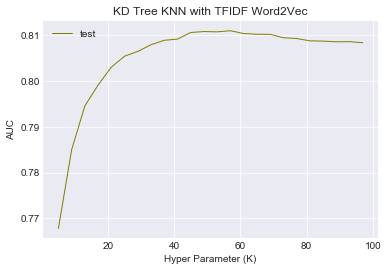

In [74]:
d = {'K':K,'train':tr_score,'test':cv_score}
line_df = pd.DataFrame(data = d)
plt.style.use('seaborn-darkgrid')
plt.plot('K', 'test', data = line_df, linewidth = 1, color = 'olive')
plt.title('KD Tree KNN with TFIDF Word2Vec')
plt.xlabel('Hyper Parameter (K)')
plt.ylabel('AUC')
plt.legend()
plt.show()

#### Observations:

KD tree KNN model with TFIDFW2V has the best AUC (81%) at K =25

In [75]:
Kdtree = KNeighborsClassifier(n_neighbors = 25,metric = 'minkowski', p=2, algorithm = 'kd_tree', weights = 'distance')
Kdtree_tfidfW2V = Kdtree.fit(tr_std_tfidfW2V,score_tr)
tr_pred_Kdtree_tfidfW2V = Kdtree_tfidfW2V.predict_proba(tr_std_tfidfW2V)[:,1]
ts_pred_Kdtree_tfidfW2V = Kdtree_tfidfW2V.predict_proba(ts_std_tfidfW2V)[:,1]
auc_Kdtree_tfidfW2V_ts = roc_auc_score(score_ts,ts_pred_Kdtree_tfidfW2V)

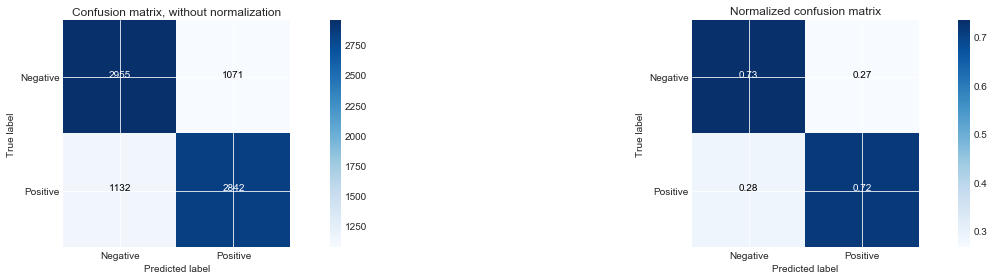

In [81]:
ts_pred = Kdtree_tfidfW2V.predict(ts_std_tfidfW2V)
cm_Kdtree_tdidfW2V = confusion_matrix(score_ts, ts_pred)
plot_confusion_matrix(cm_Kdtree_tdidfW2V,['Negative','Positive'])

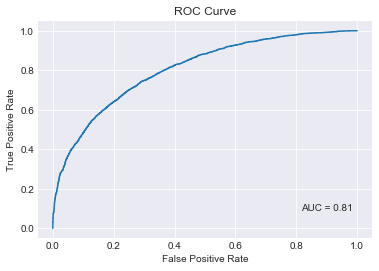

In [80]:
fpr, tpr, threshold = roc_curve(score_ts,ts_pred_Kdtree_tfidfW2V)
plt.plot(fpr,tpr)
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.text(0.9,0.1,verticalalignment = 'center', horizontalalignment = 'center', s = 'AUC = 0.81', fontsize = 10)
plt.show()

# [6] Conclusions

In [12]:
# Refer to http://zetcode.com/python/prettytable/ for PrettyTable documentation
x = PrettyTable()
x.field_names = ["Algorithm","Featurization","Optimal K","Test AUC"]
x.add_row(['Brute Force KNN','Bag of Words',149,'80%'])
x.add_row(['Brute Force KNN','TF-IDF','133','79%'])
x.add_row(['Brute Force KNN','Average Word2Vec','25','84%'])
x.add_row(['Brute Force KNN','TF-IDF Word2Vec','33','81%'])
x.sortby = 'Test AUC'
x.reversesort = True
print(x)
y = PrettyTable()
y.field_names = ["Algorithm","Featurization","Optimal K","Test AUC"]
y.add_row(['KD Tree KNN','Bag of Words','93','81%'])
y.add_row(['KD Tree KNN','TF-IDF','81','82%'])
y.add_row(['KD Tree KNN','Average Word2Vec','25','84%'])
y.add_row(['KD Tree KNN','TF-IDF Word2Vec','25','81%'])
y.sortby = 'Test AUC'
y.reversesort = True
print(y)

+-----------------+------------------+-----------+----------+
|    Algorithm    |  Featurization   | Optimal K | Test AUC |
+-----------------+------------------+-----------+----------+
| Brute Force KNN | Average Word2Vec |     25    |   84%    |
| Brute Force KNN | TF-IDF Word2Vec  |     33    |   81%    |
| Brute Force KNN |   Bag of Words   |    149    |   80%    |
| Brute Force KNN |      TF-IDF      |    133    |   79%    |
+-----------------+------------------+-----------+----------+
+-------------+------------------+-----------+----------+
|  Algorithm  |  Featurization   | Optimal K | Test AUC |
+-------------+------------------+-----------+----------+
| KD Tree KNN | Average Word2Vec |     25    |   84%    |
| KD Tree KNN |      TF-IDF      |     81    |   82%    |
| KD Tree KNN | TF-IDF Word2Vec  |     25    |   81%    |
| KD Tree KNN |   Bag of Words   |     93    |   81%    |
+-------------+------------------+-----------+----------+


Average Word2Vec featurization based models seem to working well for the data. Both KD tree and Brute Force methods result in same AUC. But, if accuracy is taken into consideration, KD Tree approach seems the best of all.